# Wisconsin Autonomous Perception Challenge Spring 2025
## Grant Hohol

### Import necessary libraries

In [385]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load image

In [386]:
image = cv2.imread('red.png')

if image is None:
    print("Error: Image not found!")
    exit()

# Make copy to draw lines later
orig_image = image.copy()

### Output image

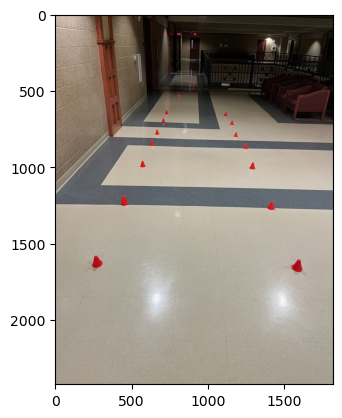

In [387]:
# Convert to RGB to output since cv2 loads in BGR
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

### Convert again to HSV so we can isolate orange for thresholding

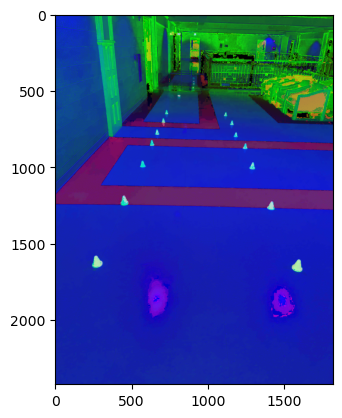

In [388]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(hsv)
plt.show()

### Thresholding to isolate orange cones

It is difficult and tedious to find the correct bounds and this is something I want to learn better techniques for

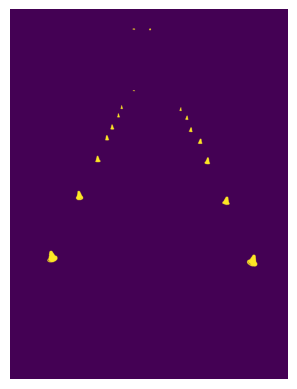

In [389]:
# Define bounds for orange
lower = np.array([0, 160, 160]) # (Hue, Saturation, Value)
upper = np.array([255, 255, 255])

# create mask
mask = cv2.inRange(hsv, lower, upper)

plt.imshow(mask)
plt.axis('off')
plt.show()

Seems to isolate the cones pretty well, although there are some other faint objects the mask is detecting up top

### Save mask to check in binary color

In [390]:
cv2.imwrite('mask.png', mask)

True

### Find contours in the cones

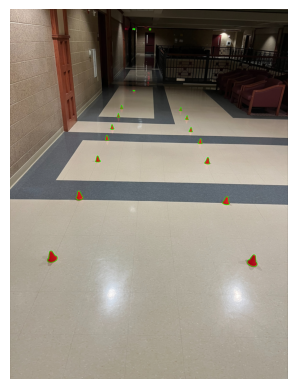

In [391]:
# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_rgb2 = image_rgb.copy() # making a copy to make another contour overlay later

# overlay contours on image_rgb
cv2.drawContours(image_rgb, contours, -1, (0, 255, 0), 2)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()



Contours are indeed picking up the spots up top that are not cones that were a bit visible in the mask.

Trying to filter out the smaller contours up top that the mask could not filter out. 

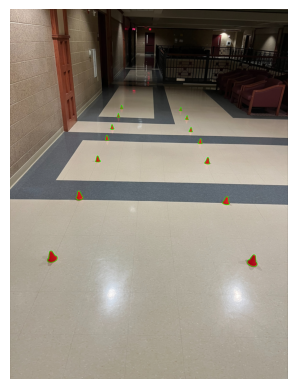

In [392]:
# Filter out small contours (noise up top)
min_contour_area = 100 
filtered_contours = [cont for cont in contours if cv2.contourArea(cont) > min_contour_area]

cv2.drawContours(image_rgb2, filtered_contours, -1, (0, 255, 0), 2)

plt.imshow(image_rgb2)
plt.axis('off')
plt.show()


In [393]:
print(f"Number of contours found: {len(filtered_contours)}")

Number of contours found: 14


In [394]:
cv2.imwrite('contours.png', image_rgb2)

True

Filtering was successful. We correctly have 14 contours for 14 cones

### Computer centroid of the contours

In [395]:
centroids = [] # list of centroids of cones

for cont in filtered_contours:
    M = cv2.moments(cont) # returns dictionary of moments
    if M['m00'] != 0: # assure area of contour is not 0

        # compute centroids x and y pixel values
        # I understand that this is how you compute it and that m00 is area, but I would like to learn more about
        # why this is the case and further understanding first order spatial moments
        cx = int(M['m10'] / M['m00']) # x pixel coord of centroid
        cy = int(M['m01'] / M['m00']) # y pixel coord of centroid
        centroids.append([cx, cy])

print(f"Centroids: \n{centroids}")

Centroids: 
[[1584, 1650], [275, 1624], [1412, 1257], [453, 1224], [1289, 996], [573, 984], [1242, 867], [633, 844], [1180, 791], [667, 774], [1155, 713], [708, 698], [1114, 656], [729, 644]]


### Cluster the centroids into two left and right groups using K means clustering so we can create two lines

In [396]:
# K means requires numpy array
centroids_np = np.array(centroids, dtype=np.float32)

# stopping criteria for kmeans function call
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# call kmeans to split into two clusters; returns 2d array of which cluster the centroid at the matching 
# index in "centroids_np" belongs to
_, labels, centers = cv2.kmeans(centroids_np, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


labels

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

Split up evenly between 1 and 0 is a good sign

In [397]:
# split into two clusters
cluster1 = centroids_np[labels.flatten() == 0]
cluster2 = centroids_np[labels.flatten() == 1]


# Determine which cluster is left/right based on x-coordinate
if np.mean(cluster1[:, 0]) < np.mean(cluster2[:, 0]):
    left = cluster1
    right = cluster2
else:
    left = cluster2
    right = cluster1

print(f"Left Cluster: \n{left}\n\nRight Cluster: \n{right}")

Left Cluster: 
[[ 275. 1624.]
 [ 453. 1224.]
 [ 573.  984.]
 [ 633.  844.]
 [ 667.  774.]
 [ 708.  698.]
 [ 729.  644.]]

Right Cluster: 
[[1584. 1650.]
 [1412. 1257.]
 [1289.  996.]
 [1242.  867.]
 [1180.  791.]
 [1155.  713.]
 [1114.  656.]]


We can see from the points that this is correct because the right cluster has all higher x-values

### Fit a line through each cluster

In [398]:
def fit_line(cluster, image_height):
    """
    Fits a straight line to a set of points (cluster) using the least squares method, 
    and calculates the endpoints of the line based on the image height.

    Args:
    cluster (numpy.ndarray): A numpy array of points (x, y) representing the 
                              coordinates of the cluster that we want to fit a line to.
                              The cluster should be a 2D array of shape (n, 1, 2), where 
                              `n` is the number of points.
    image_height (int): The height of the image (used to compute the y-axis range 
                        for the line's endpoints).

    Returns:
    tuple: A tuple containing two points representing the endpoints of the fitted line. 
           Each point is a tuple of (x, y) coordinates. The first point corresponds 
           to the leftmost x-coordinate (at y=0), and the second point corresponds 
           to the rightmost x-coordinate (at y=image_height).    
    """
    
    line = cv2.fitLine(cluster, cv2.DIST_L2, 0, 0.01, 0.01)
    vx = line[0][0]  # x-component of the direction vector
    vy = line[1][0]  # y-component of the direction vector
    x0 = line[2][0]   # x-coordinate of a point on the line
    y0 = line[3][0]   # y-coordinate of a point on the line

    # calcuate two points to draw linear line
    y_min = 0
    y_max = image_height
    slope = vx/vy # rise over run
    x_min = int(x0 + (y_min - y0) * (slope))
    x_max = int(x0 + (y_max - y0) * (slope))

    return (x_min, y_min), (x_max, y_max)

height = orig_image.shape[0]

# get two end points for each of the two lines
left_line_end_pts = fit_line(left, height) 
right_line_end_pts = fit_line(right, height)

### Draw lines and save image

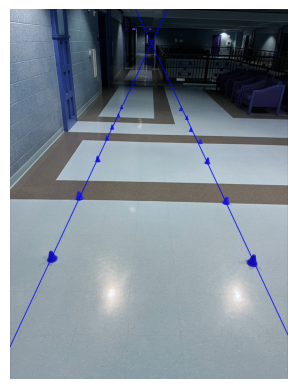

In [399]:
# Draw line over original image from calculated end points
cv2.line(orig_image, left_line_end_pts[0], left_line_end_pts[1], (0, 0, 255), 3)
cv2.line(orig_image, right_line_end_pts[0], right_line_end_pts[1], (0, 0, 255), 3)

plt.imshow(orig_image)
plt.axis('off')
plt.show()

Looks good! Lets save it

In [400]:
cv2.imwrite('answer.png', orig_image)


True